Chapter 22

# 马尔科夫链蒙特卡罗模拟
Book_5《统计至简》 | 鸢尾花书：从加减乘除到机器学习 (第二版)

该代码使用马尔科夫链蒙特卡罗（MCMC）方法估计后验分布，基于先验知识和观测数据来估计二项分布参数 $\theta$ 的概率分布。具体地，该代码采用一个贝叶斯框架来计算给定 $n = 200$ 个样本中 $h = 60$ 个兔子观测的后验分布。

1. **目标后验 PDF**：首先，定义了目标后验概率密度函数：
   $$
   P(\theta | h) \propto P(h | \theta) \cdot P(\theta)
   $$
   其中，似然 $P(h | \theta)$ 为二项分布，先验 $P(\theta)$ 取 Beta 分布。

2. **MCMC 数据生成**：定义了 Metropolis-Hastings 算法，用于通过采样获得参数 $\theta$ 的后验分布。采样的初始值为 $\theta_0 = 0.1$，并设置总迭代次数为 5000 次。在每次迭代中，算法根据当前 $\theta$ 生成新候选 $\theta$，并通过接受概率 $\rho = \min(1, \frac{P(\theta' | h)}{P(\theta | h)})$ 选择接受或拒绝新候选。

3. **结果可视化**：通过不同的 $\alpha$ 参数绘制 Beta 分布先验分布对后验的影响。对于每个 $\alpha = 1, 2, 8, 16, 32, 64$，计算并绘制先验和后验的直方图，并将 MCMC 结果与解析后验分布对比，验证采样的有效性。

4. **多链收敛性分析**：代码最后生成 5 条不同初始值的马尔科夫链，以观察链的收敛情况。各链的收敛性图像表明，在相对较少的迭代步数（100步）内，各链趋向稳定，从而验证算法的收敛性。

## 导入所需的库

In [1]:
import scipy.stats as stats  # 导入统计函数库
import numpy as np  # 导入数值计算库
import matplotlib.pyplot as plt  # 导入绘图库

## 定义目标概率密度函数

In [2]:
def target_PDF(likelihood, prior, n, h, theta):
    """
    计算目标分布的概率密度函数
    参数:
        likelihood - 似然函数
        prior - 先验分布
        n - 样本总数
        h - 事件发生次数
        theta - 待估计参数值
    返回:
        后验分布值
    """
    if theta < 0 or theta > 1:
        return 0
    else:
        likelihood_fcn = likelihood(n, theta).pmf(h)  # 计算似然值
        prior_fcn = prior.pdf(theta)  # 计算先验值
        posterior_fcn = likelihood_fcn * prior_fcn  # 计算后验值
        return posterior_fcn

## 数据生成器 - MCMC采样

In [3]:
def data_generator(num_iterations, n, s, 
                   theta_0, likelihood, prior, 
                   drop_unstable=True,
                   sigma=0.3):
    """
    使用MCMC生成数据
    参数:
        num_iterations - 迭代次数
        n - 样本总数
        s - 事件发生次数
        theta_0 - 初始theta值
        likelihood - 似然函数
        prior - 先验分布
        drop_unstable - 是否去掉不稳定前半部分
        sigma - 正态分布的标准差
    返回:
        生成的theta样本
    """
    samples = [theta_0]  # 样本存储容器，初始值为theta_0
    num_accepted = 0  # 计数接受的样本数
    theta_now = theta_0  # 初始化当前theta值
    
    for idx in range(num_iterations):
        delta_theta = stats.norm(0, sigma).rvs()  # 生成正态扰动
        theta_next = theta_now + delta_theta  # 更新theta值
        numerator = target_PDF(likelihood, prior, n, s, theta_next)
        denominator = target_PDF(likelihood, prior, n, s, theta_now)
        
        rho = min(1, numerator / denominator)  # 计算接受概率
        u_idx = np.random.uniform()  # 生成随机数
        
        if u_idx < rho:  # 判断是否接受新样本
            num_accepted += 1
            theta_now = theta_next
            
        samples.append(theta_now)  # 存储样本
        efficiency = num_accepted / num_iterations  # 计算接受效率
    
    if drop_unstable:  # 丢弃前一半的样本
        nmcmc = len(samples) // 2
        samples = samples[nmcmc:]
        
    return samples

## 参数初始化

In [4]:
theta_array = np.linspace(0, 1, 500)  # 生成theta的取值范围
n = 200  # 样本总数
s = 60  # 事件发生次数
theta_0 = 0.1  # 初始theta值
num_iterations = 5000  # MCMC迭代次数
    

## 生成先验分布和后验分布

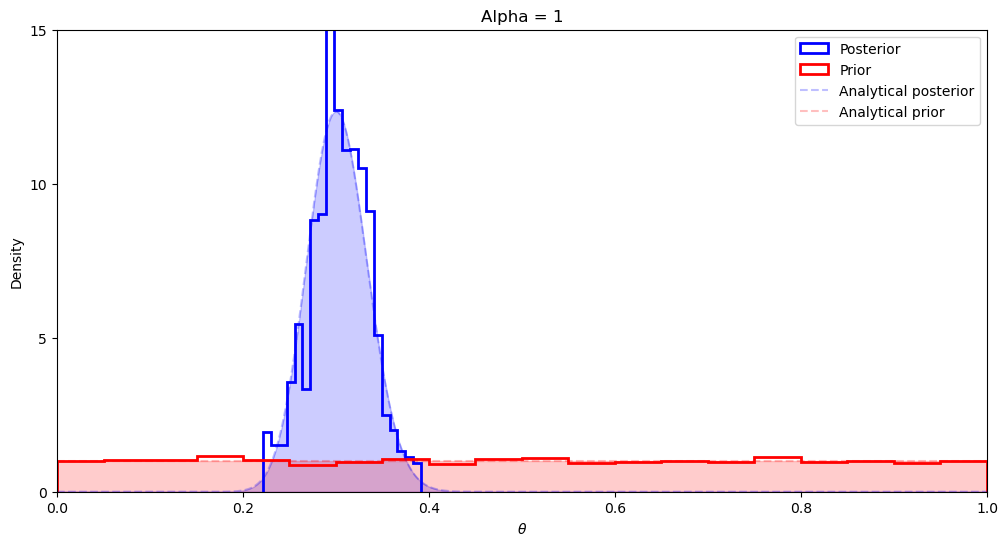

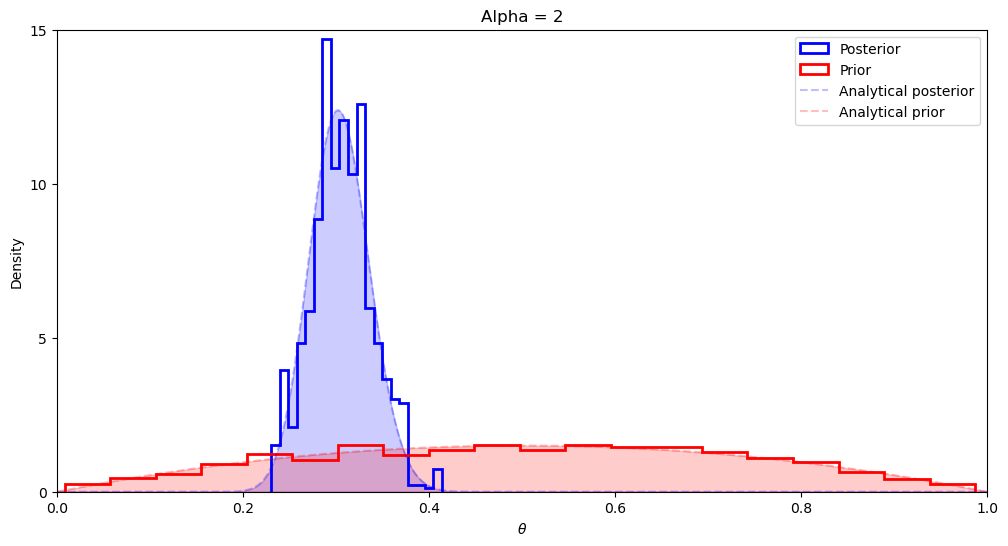

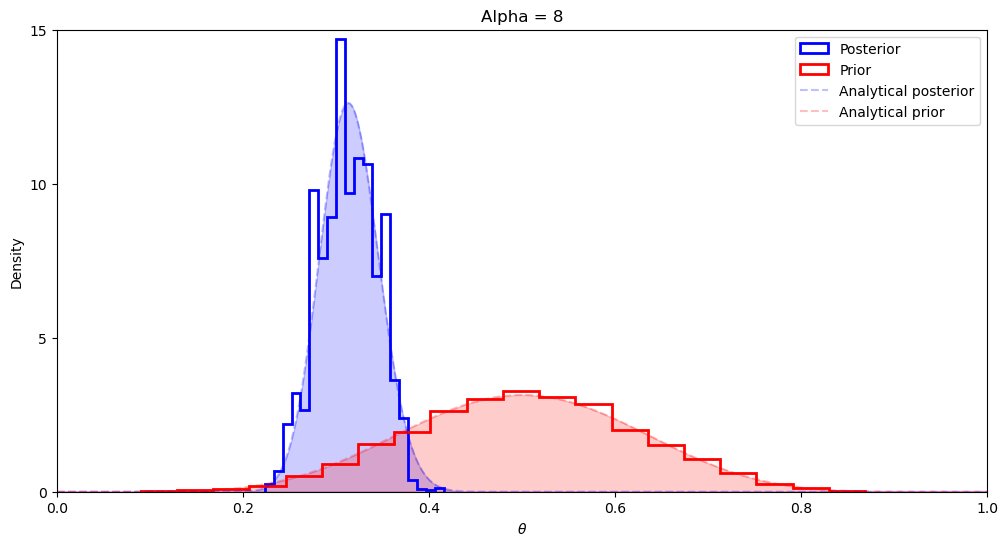

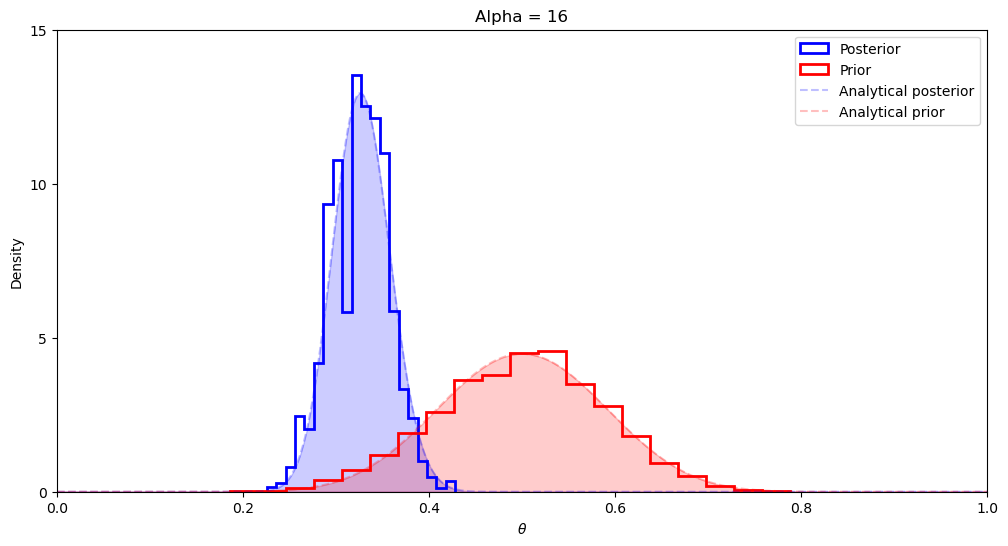

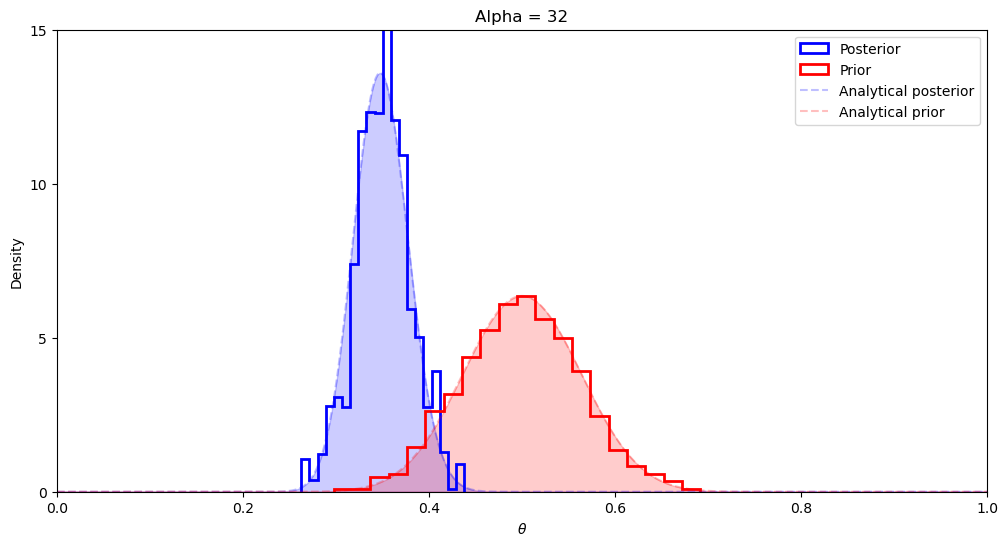

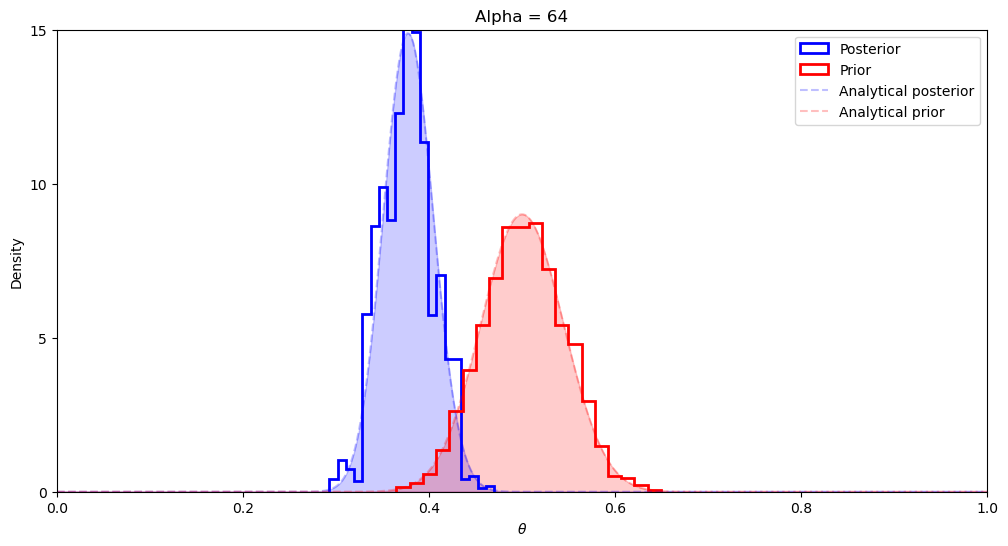

In [5]:
alpha_arrays = [1, 2, 8, 16, 32, 64]  # 先验分布的alpha参数列表

for alpha in alpha_arrays:
    beta = alpha  # 设置Beta分布参数
    likelihood = stats.binom  # 选择二项分布作为似然函数
    prior = stats.beta(alpha, beta)  # 定义先验分布
    post = stats.beta(s + alpha, n - s + beta)  # 定义后验分布
    
    samples = data_generator(num_iterations, n, s, theta_0, likelihood, prior)  # 生成样本
    
    fig, ax = plt.subplots(figsize=(12, 6))  # 创建绘图窗口
    
    plt.hist(samples, 20, histtype='step', density=True, linewidth=2, color='b', label='Posterior')  # 绘制后验分布样本直方图
    plt.hist(prior.rvs(len(samples)), 20, histtype='step', density=True, linewidth=2, color='r', label='Prior')  # 绘制先验分布样本直方图
    
    plt.plot(theta_array, post.pdf(theta_array), c='b', linestyle='--', alpha=0.25, label='Analytical posterior')  # 绘制解析后验分布
    plt.fill_between(theta_array, 0, post.pdf(theta_array), color='b', alpha=0.2)  # 填充后验分布
    
    plt.plot(theta_array, prior.pdf(theta_array), c='r', linestyle='--', alpha=0.25, label='Analytical prior')  # 绘制解析先验分布
    plt.fill_between(theta_array, 0, prior.pdf(theta_array), color='r', alpha=0.2)  # 填充先验分布
    
    plt.xlim([0, 1])  # 设置x轴范围
    plt.ylim([0, 15])  # 设置y轴范围
    plt.yticks([0, 5, 10, 15])  # 设置y轴刻度
    plt.legend(loc='best')  # 显示图例
    plt.xlabel(r'$\theta$')  # x轴标签
    plt.ylabel('Density')  # y轴标签
    plt.title('Alpha = %0.0f' % alpha)  # 图标题

## 稳定性分析

In [ ]:
alpha = 16  # 设置Beta分布参数
beta = alpha
likelihood = stats.binom
prior = stats.beta(alpha, beta)

num_iterations = 100  # 设置迭代次数
samples_5_sets = [data_generator(num_iterations, n, s, theta_0, likelihood, prior, drop_unstable=False, sigma=0.1) 
                  for theta_0 in np.linspace(0.1, 0.9, 5)]  # 使用不同初始值生成多个样本集

## 绘制多个MCMC链的收敛情况

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))  # 创建绘图窗口

for data_idx in samples_5_sets:
    plt.plot(data_idx, '-o')  # 绘制每个链的样本收敛曲线

plt.xlim([0, num_iterations])  # 设置x轴范围
plt.xlabel('Iteration')  # 设置x轴标签
plt.ylim([0, 1])  # 设置y轴范围
plt.ylabel(r'$\theta$')  # 设置y轴标签

In [ ]:
# =============================================================================
# # reference:
# # https://people.duke.edu/~ccc14/cspy/16A_MCMC.html
# =============================================================================